Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

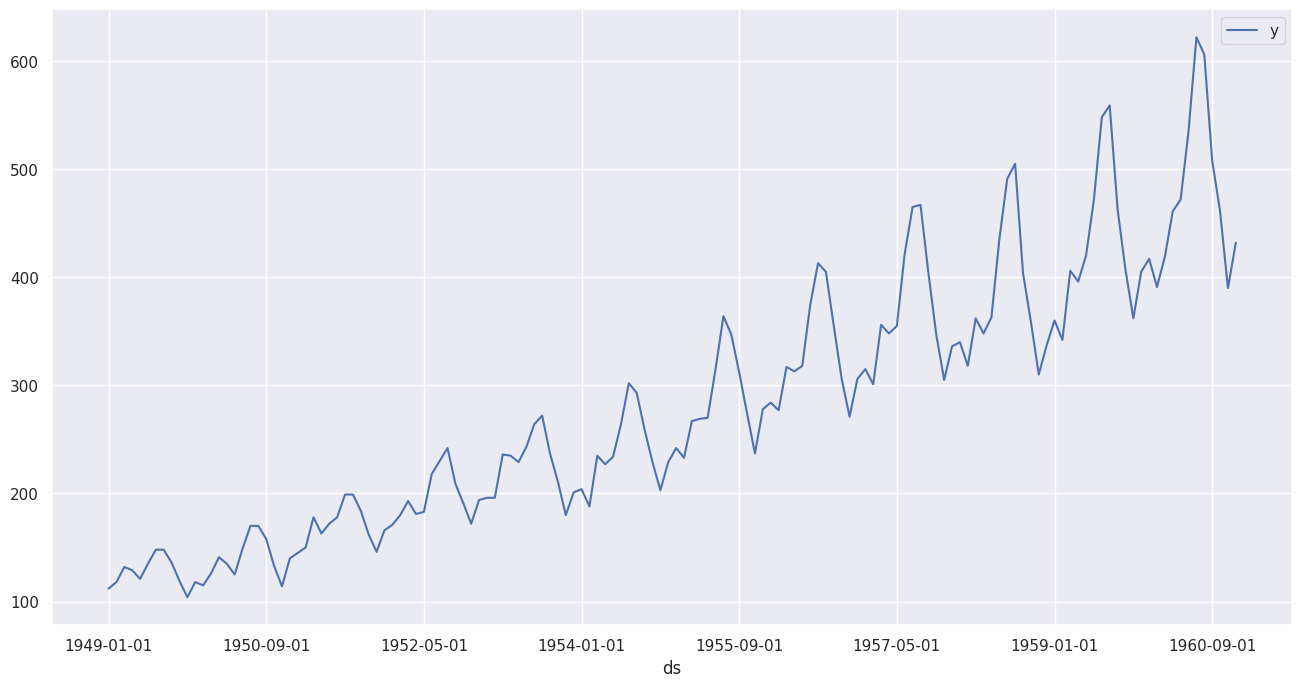

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# # Default model request
# model_request = {
#     'type': 'meta_lr',  # 'meta_wa'
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer', 'params': {'strategy': 'mean'}},
#             # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_rnn'},
#             {'type': 'darts_lightgbm'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#             # {'type': 'stats_autotheta'},
#             # {'type': 'stats_autoarima'},
#             # {'type': 'stats_autoets'},
#         ],
#     },
# }

# Customized model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer', 'params': {'strategy': 'mean'}},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_naive'},
            {'type': 'darts_seasonalnaive'},
            {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            {'type': 'darts_autoets'},
            # {'type': 'stats_autoets'},
            {'type': 'darts_autoarima'},
            # {'type': 'stats_autoarima'},
            {'type': 'darts_tbats'},
            {'type': 'darts_linearregression'},
            # {'type': 'darts_lightgbm', 'params': {'lags': 12, 'output_chunk_length': 6, 'verbose': -1}}, 
            # {'type': 'darts_rnn', 'params': {'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 3}},
        ],
    },
}

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 4.18 ms, sys: 191 µs, total: 4.37 ms
Wall time: 57.4 s


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCP4dAQD4HQEA4q0AABgAAADYrQAARxUAAD+AAGVsaZOMb5Rsb4xtlARhaZRNYYFpYWlhjIwuYQtlgR9hbIxylBcuZmlsTmlnfWlyYWWMcoF0lIx4b2FEeX1vaB9hdpRWlJRzX3hveGFlcIFhcG94dF9lZQ1llHRkc5RfZR95k2FhYZRplE51dAJSlP99S4Z1ZXJydYx5QyhXh1v/fR9LhgSoLMVJfgI3uz91+S6yNs5SiAxBxUl/Azi8QNhckh8WS89TiAxCxkoxtepuoyer4WWaHqI6vvR4rTG162+kKB+sRMj+grc7v/R4rjK2TtIHi8FFyf6CuDzApipg5BmdIR9X2xCUGLA0au4jpytg5BqeIro+dPctsTVq7iSoLMRIfR8BN7s/dPgusjYcoNZajxOXzVGGlJRuhnSGdF9njGWUgh+BjC5kc3eTZCgAlGiIjP//lGJSVZROlH2Ub2l9YXJlZAmUlHgouJQAlGgA4IYAH5R2c3RmCmeJY4xLeIyMZHUprGiFKJSUlMOMTmEIZX2CCmVoh5BXh1v/dABA4IYAH5RpaQlodYxpjGFpdmUCb19ub3ZvdV90c3Vyck5jY2VzDl90ZXV2lHNfdGNzX3RldGAKH2Zlb2Fsc3KTbm5oZGVuTm9paIcBQ3uMC2FjlGxpYQFlHnKUbQ5lTn0NYZQoKDNoOmhoKJRoe32UlIKBaEyUS4mB1B9OYpSUSGgNaGgBQmsD6ICIICfAWWD4AJgxFa61TlXuhh+NJi3GXkPc43uDG7S7VFvzjAKbojpC2nN6ExqySzDIzx9obwigqEBI4Hld9v2WnTbO1W51DqaLIyvDy2P8A5yjOx/USuLqgooiu8JaYvqTeBAXsLdQ6PCIjyjBpT5F3uV9Fh8dtr1W7tNrcwsSq0RL4+uDHJIqMsrRagMKoqpiS7x1dR8vYk5oY2dLlHhoAWiBaGiFKAEEAICAIEDggIAAwACAwB+AoOBAo

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 31.4 ms


In [28]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1960-12-31T00:00:00', 415.3371102816665],
  ['1961-01-30T00:00:00', 393.3363384847501],
  ['1961-03-01T00:00:00', 427.8190019516285],
  ['1961-03-31T00:00:00', 470.7992980356891],
  ['1961-04-30T00:00:00', 484.2121295511154],
  ['1961-05-30T00:00:00', 566.346622950203],
  ['1961-06-29T00:00:00', 653.3510285306818],
  ['1961-07-29T00:00:00', 644.546781282095],
  ['1961-08-28T00:00:00', 539.949887060254],
  ['1961-09-27T00:00:00', 484.404440964411],
  ['1961-10-27T00:00:00', 405.0455774947183],
  ['1961-11-26T00:00:00', 462.2541715781709],
  ['1961-12-26T00:00:00', 467.6294625273734],
  ['1962-01-25T00:00:00', 443.0463812414311],
  ['1962-02-24T00:00:00', 483.97453049243387],
  ['1962-03-26T00:00:00', 525.2084673499305],
  ['1962-04-25T00:00:00', 536.9777272613871],
  ['1962-05-25T00:00:00', 622.5918908318945],
  ['1962-06-24T00:00:00', 713.8645181856384],
  ['1962-07-24T00:00:00', 704.5126084897752],
  ['1962-08-23T00:00:00', 593.2856605150398],
  ['1962-09-22T00:00:00', 534

Combine forecast dates and output

In [29]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [30]:
forecast_df.shape

(24, 2)

In [31]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [32]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,415.337110
1,1961-01-30T00:00:00,393.336338
2,1961-03-01T00:00:00,427.819002
3,1961-03-31T00:00:00,470.799298
4,1961-04-30T00:00:00,484.212130


In [33]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,704.512608
20,1962-08-23T00:00:00,593.285661
21,1962-09-22T00:00:00,534.466546
22,1962-10-22T00:00:00,450.896557
23,1962-11-21T00:00:00,513.218796


Plot train and forecast side-by-side

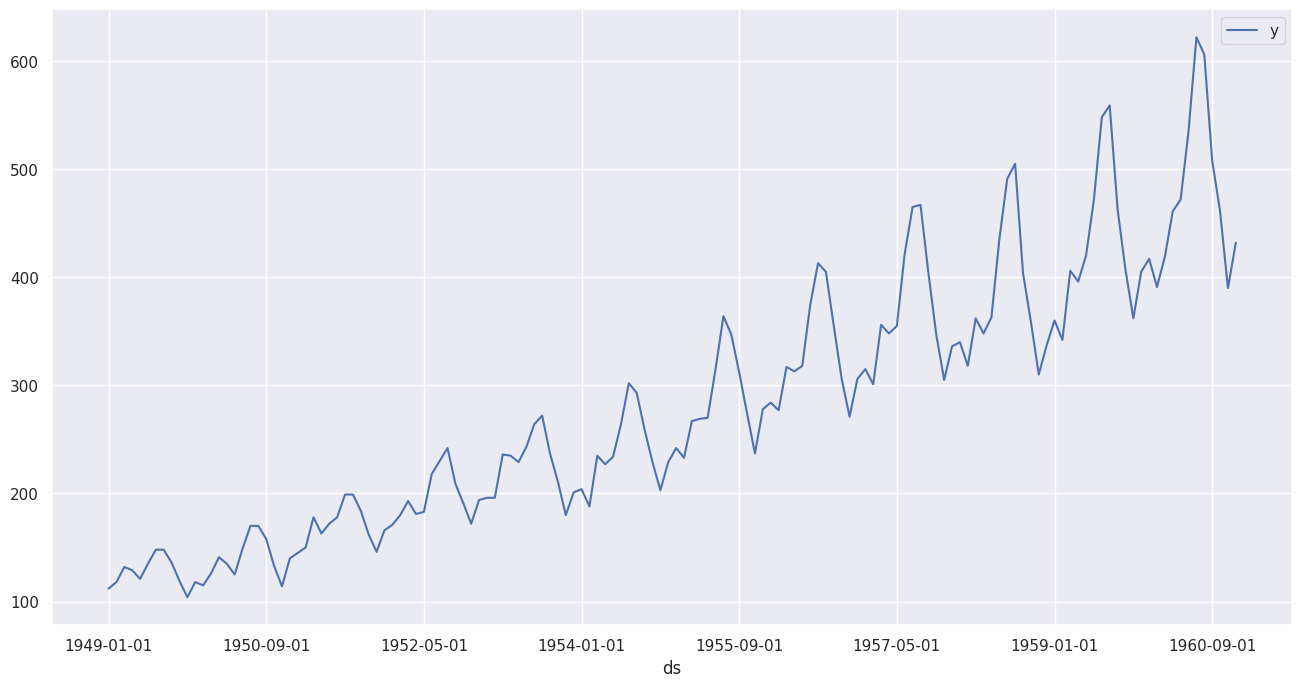

In [34]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

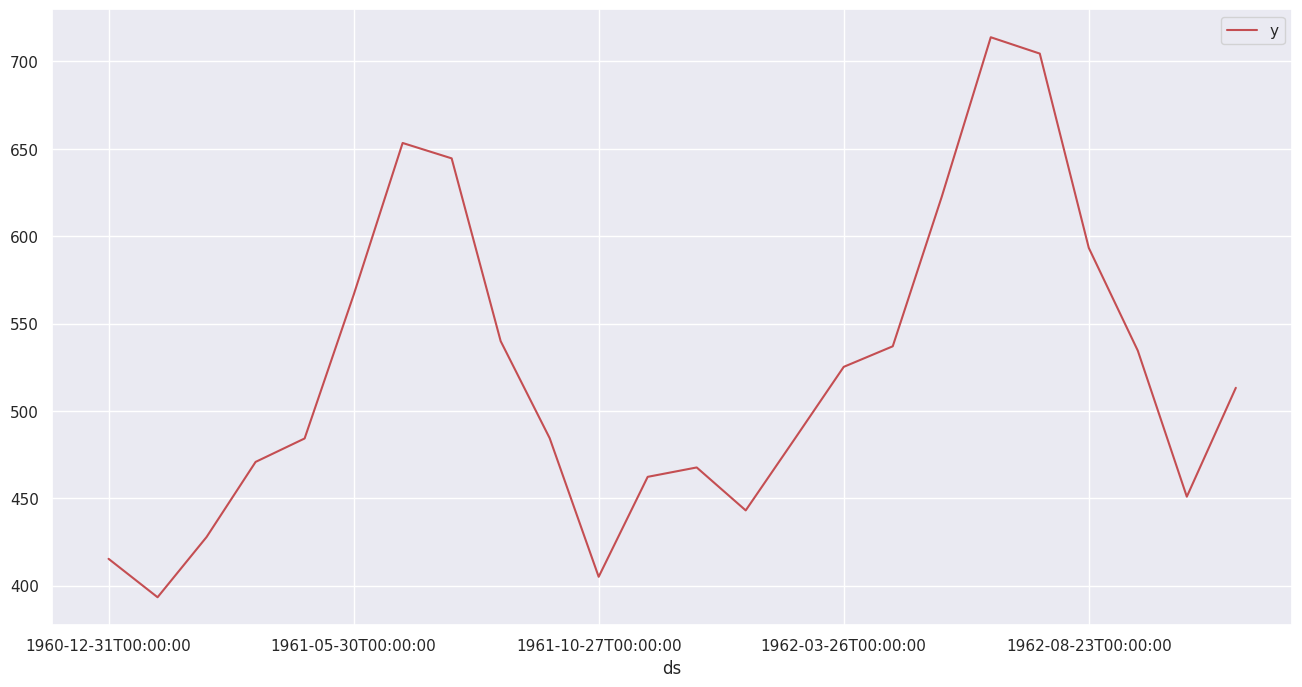

In [35]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [36]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [37]:
df.shape

(168, 3)

In [38]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [39]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,704.512608,r
164,1962-08-23T00:00:00,593.285661,r
165,1962-09-22T00:00:00,534.466546,r
166,1962-10-22T00:00:00,450.896557,r
167,1962-11-21T00:00:00,513.218796,r


Plot combined train and forecast sets with the vertical black line as the cut-off

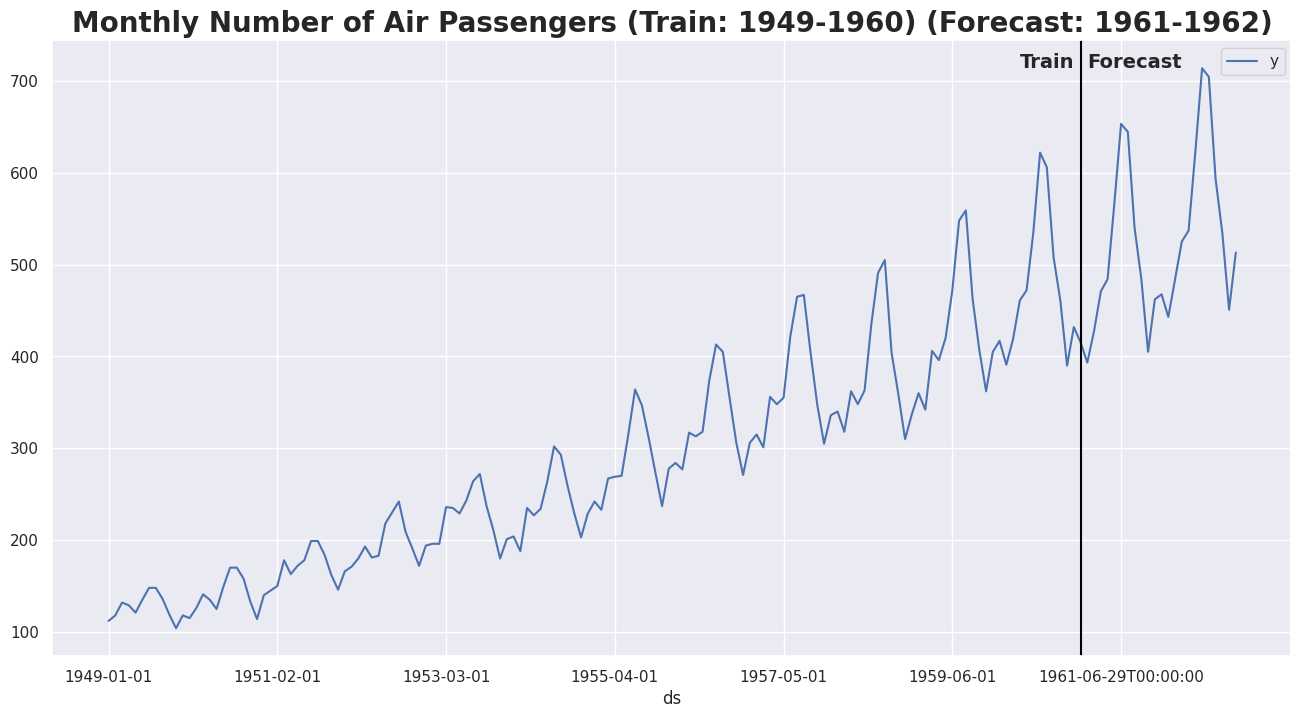

In [40]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();

In [41]:
print(train_data[-1] , forecast_df.head(1))

['1960-12-01', 432.0]                     ds          y color
0  1960-12-31T00:00:00  415.33711     r
